In [64]:
import random
import pickle
import numpy as np
from tqdm import tqdm
from skimage.measure import label
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.filters import threshold_otsu
from scipy.ndimage.filters import convolve
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [3]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

In [21]:
data = pickle.load(open('../../../../../get_data/rorb_lm.pkl', 'rb'))
print(data.keys())
print(data['synapsin'].shape)
features = np.stack([data['synapsin'][:40, :, :],
                     data['PSD95'][:40, :, :],
                     data['VGlut1'][:40, :, :]])
features = np.moveaxis(features, 0, -1)
print(features.shape)

dict_keys(['synapsin', 'VGlut1', 'GABA', 'GAD2', 'PSD95', 'GluN1', 'MBP', 'Gephyrin'])
(49, 460, 438)
(40, 460, 438, 3)


In [8]:
labels = pickle.load(open('../../../../../get_data/rorb_annotation_downsample.pkl', 'rb'))
print(labels.keys())

dict_keys(['m247514_Site3Annotation_MN_global'])


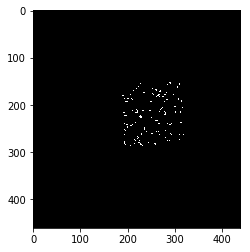

In [15]:
gt = label(labels['m247514_Site3Annotation_MN_global'])
plt.figure()
plt.imshow(gt[20] > 0, cmap='gray')
plt.show()

In [24]:
arealist = np.where(gt > 0)
z_bounds = [np.min(arealist[0]), np.max(arealist[0])]
y_bounds = [np.min(arealist[1]), np.max(arealist[1])]
x_bounds = [np.min(arealist[2]), np.max(arealist[2])]

In [25]:
print(z_bounds)
print(y_bounds)
print(x_bounds)

[0, 39]
[152, 288]
[149, 317]


In [54]:
label_annot = gt[z_bounds[0]:z_bounds[1],
                          y_bounds[0]:y_bounds[1],
                          x_bounds[0]:x_bounds[1]]

known_features = features[z_bounds[0]:z_bounds[1],
                            y_bounds[0]:y_bounds[1],
                            x_bounds[0]:x_bounds[1],
                            :]
print(label_annot.shape)
known_features = np.moveaxis(known_features, -1, 0)
print(known_features.shape)


(39, 136, 168)
(3, 39, 136, 168)


In [55]:
def compute_convolutional_cov(vol1, vol2, kernel_shape):
    vol1 = (vol1 - np.mean(vol1))/np.std(vol1)
    vol2 = (vol2 - np.mean(vol2))/np.std(vol2)
    mu_kernel = np.ones(kernel_shape)/float(np.sum(np.ones(kernel_shape)))
    e1 = convolve(vol1, mu_kernel)
    e2 = convolve(vol2, mu_kernel)

    e12 = convolve(np.log(np.exp(vol1)+np.exp(vol2)), mu_kernel)

    cov = e12 - np.log(np.exp(e1) + np.exp(e2))

    return cov

In [56]:
ccov_vol = compute_convolutional_cov(known_features[0],
                                     known_features[1],
                                    (2, 3, 3))
feature_data = [elem for elem in known_features]
feature_data.append(ccov_vol)
feature_data = np.stack(feature_data)
print(feature_data.shape)

(4, 39, 136, 168)


In [70]:
def get_train_idx_list(ratio):
    print('1')
    synapses = np.unique(label_annot)
    print('2')
    slice_max = int(ratio * len(synapses))
    print('3')
    random.shuffle(synapses)
    train_set = synapses[:slice_max]
    return train_set

In [80]:
def make_positive_feature_vector(train_idx, r):
    centroid = [int(np.mean(elem))\
                for elem in np.where(label_annot == train_idx)]
    minz = max(int(centroid[0]-r/2), 0)
    maxz = min(int(centroid[0]+r/2), 39)
    
    miny = max(centroid[1]-r, 0)
    maxy = min(centroid[1]+r, 136)
    
    minx = max(centroid[2]-r, 0)
    maxx = min(centroid[2]+r, 168)
    
    cutout = feature_data[:, minz:maxz, miny:maxy, minx:maxx]
    feature_vector = [np.mean(cutout[i]) for i in range(feature_data.shape[0])]
    return feature_vector

In [81]:
def propose_negative_coordinates(r):
    centroid = [int(np.random.random() * (elem-1))\
                          for elem in feature_data.shape[1:]]
    
    minz = max(int(centroid[0]-r/2), 0)
    maxz = min(int(centroid[0]+r/2), 39)
    
    miny = max(centroid[1]-r, 0)
    maxy = min(centroid[1]+r, 136)
    
    minx = max(centroid[2]-r, 0)
    maxx = min(centroid[2]+r, 168)
   
    return minz, maxz, miny, maxy, minx, maxx
    
    
def make_negative_feature_vector(r):
    minz, maxz, miny, maxy, minx, maxx = propose_negative_coordinates(r)
    while np.max(label_annot[minz:maxz, miny:maxy, minx:maxx]) > 0:
        minz, maxz, miny, maxy, minx, maxx = propose_negative_coordinates(r)
    
    cutout = feature_data[:, minz:maxz, miny:maxy, minx:maxx]
    feature_vector = [np.mean(cutout[i]) for i in range(feature_data.shape[0])]
    return feature_vector

In [82]:
def run_lda_sim(train_ratio, radius):
    #get random data split
    train_idx_list = get_train_idx_list(train_ratio)
    train_positives = [make_positive_feature_vector(train_idx, radius)\
                       for train_idx in train_idx_list]
    train_negatives = [make_negative_feature_vector(radius)\
                       for _ in train_positives]
    
    train_feature_vectors = train_positives + train_negatives
    train_labels = [1 for _ in train_positives] + [0 for _ in train_negatives]
    
    #train model
    lda_model = LDA()
    lda_model.fit(train_feature_vectors, train_labels)
    
    #test model
    test_positive_idx_list = [elem\
                              for elem in np.unique(label_annot)\
                              if not elem in train_idx_list]
    
    test_positives = [make_positive_feature_vector(elem, radius)\
                      for elem in test_positive_idx_list]
    
    test_negatives = [make_negative_feature_vector(radius)\
                      for _ in train_positives]
    
    positive_predictions = lda_model.predict(test_positives)
    negative_predictions = lda_model.predict(test_negatives)
    
    #compute precision and recall
    rec = np.sum(positive_predictions)/len(test_positives)
    prec = np.sum(positive_predictions)/(np.sum(positive_predictions) + np.sum(negative_predictions))
    
    return prec, rec, len(train_feature_vectors)

In [83]:
def run_qda_sim(train_ratio, radius):
    #get random data split
    train_idx_list = get_train_idx_list(train_ratio)
    train_positives = [make_positive_feature_vector(train_idx, radius)\
                       for train_idx in train_idx_list]
    train_negatives = [make_negative_feature_vector(radius)\
                       for _ in train_positives]
    
    train_feature_vectors = train_positives + train_negatives
    train_labels = [1 for _ in train_positives] + [0 for _ in train_negatives]
    
    #train model
    lda_model = QDA()
    lda_model.fit(train_feature_vectors, train_labels)
    
    #test model
    test_positive_idx_list = [elem\
                              for elem in np.unique(label_annot)\
                              if not elem in train_idx_list]
    
    test_positives = [make_positive_feature_vector(elem, radius)\
                      for elem in test_positive_idx_list]
    
    test_negatives = [make_negative_feature_vector(radius)\
                      for _ in train_positives]
    
    positive_predictions = lda_model.predict(test_positives)
    negative_predictions = lda_model.predict(test_negatives)
    
    #compute precision and recall
    rec = np.sum(positive_predictions)/len(test_positives)
    prec = np.sum(positive_predictions)/(np.sum(positive_predictions) + np.sum(negative_predictions))
    
    return prec, rec, len(train_feature_vectors)

In [84]:
lda_trial_summaries = []
for radius in [2, 4, 6, 8]:
    print('radius: ', radius)
    prec_list = []
    rec_list = []
    for i in range(3):
        prec, rec, n = run_lda_sim(.3, radius)
        prec_list.append(prec)
        rec_list.append(rec)
    lda_trial_summaries.append({'train_samples': n,
                            'radius': radius,
                            'ave_prec': np.mean(prec_list),
                            'var_prec': np.var(prec_list),
                            'ave_rec': np.mean(rec_list),
                            'var_rec': np.var(rec_list)})

radius:  2
1
2
3
a
b
c
d
e
1
2
3
a
b
c
d
e
1
2
3
a
b
c
d
e
radius:  4
1
2
3
a
b
c
d
e
1
2
3
a
b
c
d
e
1
2
3
a
b
c
d
e
radius:  6
1
2
3
a
b
c
d
e
1
2
3
a
b
c
d
e
1
2
3
a
b
c
d
e
radius:  8
1
2
3
a
b
c
d
e
1
2
3
a
b
c
d
e
1
2
3
a
b
c
d
e


In [92]:
qda_trial_summaries = []
for radius in [2, 4, 6, 8]:
    prec_list = []
    rec_list = []
    for i in range(3):
        prec, rec, n = run_qda_sim(.33, radius)
        prec_list.append(prec)
        rec_list.append(rec)
    qda_trial_summaries.append({'train_samples': n,
                            'radius': radius,
                            'ave_prec': np.mean(prec_list),
                            'var_prec': np.var(prec_list),
                            'ave_rec': np.mean(rec_list),
                            'var_rec': np.var(rec_list)})

1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3


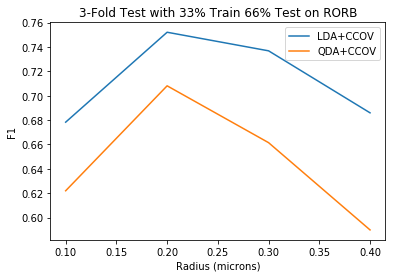

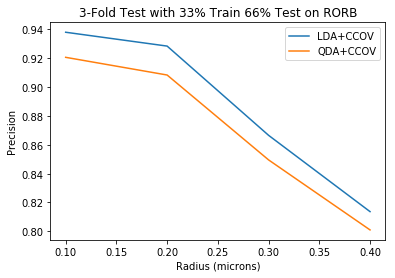

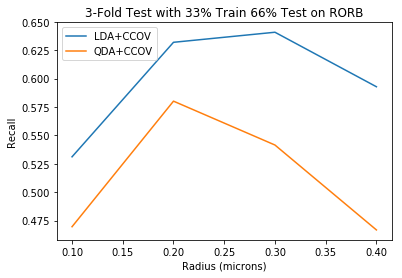

In [97]:
plt.figure()
xs = [elem['radius'] *.05 for elem in lda_trial_summaries]
ys = [2*elem['ave_prec']*elem['ave_rec']/(elem['ave_prec']+elem['ave_rec']) for elem in lda_trial_summaries]
plt.plot(xs, ys, label='LDA+CCOV')

xs = [elem['radius'] *.05 for elem in qda_trial_summaries]
ys = [2*elem['ave_prec']*elem['ave_rec']/(elem['ave_prec']+elem['ave_rec']) for elem in qda_trial_summaries]
plt.plot(xs, ys, label='QDA+CCOV')

plt.title('3-Fold Test with 33% Train 66% Test on RORB')
plt.xlabel('Radius (microns)')
plt.ylabel('F1')
plt.legend()
plt.show()

plt.figure()
xs = [elem['radius'] * .05 for elem in lda_trial_summaries]
ys = [elem['ave_prec'] for elem in lda_trial_summaries]
plt.plot(xs, ys, label='LDA+CCOV')


xs = [elem['radius'] * .05 for elem in qda_trial_summaries]
ys = [elem['ave_prec'] for elem in qda_trial_summaries]
plt.plot(xs, ys, label='QDA+CCOV')
plt.title('3-Fold Test with 33% Train 66% Test on RORB')
plt.xlabel('Radius (microns)')
plt.ylabel('Precision')
plt.legend()
plt.show()

plt.figure()
xs = [elem['radius'] * .05 for elem in lda_trial_summaries ]
ys = [elem['ave_rec'] for elem in lda_trial_summaries]
plt.plot(xs, ys, label='LDA+CCOV')

xs = [elem['radius'] *.05 for elem in qda_trial_summaries]
ys = [elem['ave_rec'] for elem in qda_trial_summaries]
plt.plot(xs, ys, label='QDA+CCOV')

plt.title('3-Fold Test with 33% Train 66% Test on RORB')
plt.xlabel('Radius (microns)')
plt.ylabel('Recall')
plt.legend()
plt.show()


In [98]:
#get random data split
train_idx_list = get_train_idx_list(.33)
train_positives = [make_positive_feature_vector(train_idx, 4)\
                   for train_idx in train_idx_list]
train_negatives = [make_negative_feature_vector(4)\
                   for _ in train_positives]

train_feature_vectors = train_positives + train_negatives
train_labels = [1 for _ in train_positives] + [0 for _ in train_negatives]

#train models
lda_model = LDA()
lda_model.fit(train_feature_vectors, train_labels)

qda_model = QDA()
qda_model.fit(train_feature_vectors, train_labels)

1
2
3


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

In [99]:
z = 10
lda_preds = np.zeros_like(label_annot[z])
qda_preds = np.zeros_like(label_annot[z])

for y in range(label_annot.shape[1]):
    for x in range(label_annot.shape[2]):
        centroid = [z, y, x]
        
        minz = max(centroid[0]-4, 0)
        maxz = min(centroid[0]+4, 39)

        miny = max(centroid[1]-4, 0)
        maxy = min(centroid[1]+4, 136)

        minx = max(centroid[2]-4, 0)
        maxx = min(centroid[2]+4, 168)

        cutout = feature_data[:, minz:maxz, miny:maxy, minx:maxx]
        feature_vector = np.array([np.mean(cutout[i]) for i in range(feature_data.shape[0])]).reshape(1, -1)
        
        lda_preds[centroid[1], centroid[2]] = lda_model.predict(feature_vector)[0]
        qda_preds[centroid[1], centroid[2]] = qda_model.predict(feature_vector)[0]

In [100]:
def make_overlap_img(a, b):
    bin_a = a > threshold_otsu(a)
    bin_b = b > threshold_otsu(a)
    rgb_both = np.moveaxis(np.stack([bin_a, bin_b, np.zeros_like(bin_a)]), 0, -1)
    rgb_both = rgb_both.astype(float)
    return rgb_both

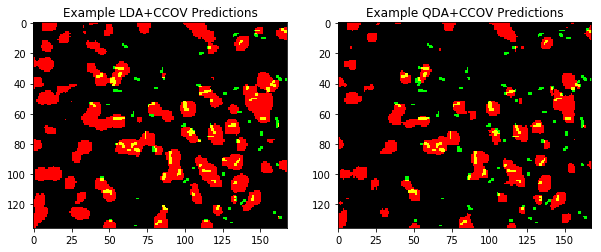

In [105]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Example LDA+CCOV Predictions')
plt.imshow(make_overlap_img(lda_preds, label_annot[z] > 0))

plt.subplot(122)
plt.title('Example QDA+CCOV Predictions')
plt.imshow(make_overlap_img(qda_preds, label_annot[z] > 0))
plt.show()